In [24]:
from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from tractseg.libs import tracking
from tractseg.libs import tractometry
from dipy.tracking.utils import length

import os,sys
import argparse
import math
from decimal import Decimal
from os.path import join
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
from tractseg.libs import plot_utils
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import skimage.filters

%matplotlib inline

In [16]:
import dipy
dipy.__version__

'1.5.0'

In [3]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","GAITnPARK")
PARA="ADC"
ALGORITHM="distance_map"
NR_POINTS=30
LAT="L"

In [4]:
df = pd.read_csv(os.path.join(STUDY_PATH,'PARKS.txt'), sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

for LAT in ["R","L"]:
    #npvalues = np.zeros([len(df),NR_POINTS])
    for idx, jdx in df.iterrows():
        npvalues = np.zeros([1,NR_POINTS])
        SUBJ=df.iloc[idx]['subject_id']
        TRACTO_TCK=os.path.join(STUDY_PATH,"DTI",SUBJ,"Tract_SN_DN_"+LAT+"_better_"+SUBJ+"_resampled.tck")
        SCALAR_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"adc.nii.gz")
        #SCALAR_IMG=os.path.join(STUDY_PATH,"R2",SUBJ+"_R2_warped.nii.gz")
        print(SCALAR_IMG)
        START_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"SN_"+LAT+"_"+SUBJ+"_binary_onB0.nii.gz") 
        scalar_image = nib.load(SCALAR_IMG)
        beginnings = nib.load(START_IMG)
        sl_file = nib.streamlines.load(TRACTO_TCK)
        streamlines = sl_file.streamlines
        val=list(length(streamlines))
        if len(streamlines) > 5 :
            mean, std = tractometry.evaluate_along_streamlines_withAlgo(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine)
            npvalues[0, :] = mean[1:-1]
        Profiles_file=os.path.join(STUDY_PATH,"DTI",SUBJ,PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
        np.savetxt(Profiles_file+".csv",np.transpose(npvalues),delimiter=',')
#    Profiles_file=os.path.join(STUDY_PATH,"PARKS_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
#    np.save(Profiles_file,npvalues)
#    np.savetxt(Profiles_file+".csv",npvalues,delimiter=',')

print(npvalues.shape)
%matplotlib inline
plt.plot(np.median(npvalues,axis=0),'b')
plt.fill_between(np.linspace(0,39,40),np.percentile(npvalues,25,axis=0),np.percentile(npvalues,75,axis=0))
plt.plot(np.transpose(npvalues),linewidth=0.1)

#plt.plot(numpy.percentile(data,75,axis=0))
#plt.plot(numpy.flipud(numpy.mean(CST_right_nd[numpy.mean(CST_right_nd,axis=1)>0.3],axis=0)))
plt.show()

/NAS/dumbo/protocoles/GAITnPARK/DTI/APPLINCOURT_MARIE_FRANCE_SES1/adc.nii.gz


AttributeError: module 'tractseg.libs.tractometry' has no attribute 'evaluate_along_streamlines_withAlgo'

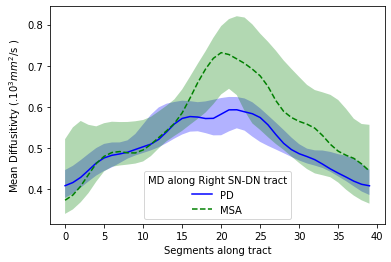

64.0 0.010007605010743582


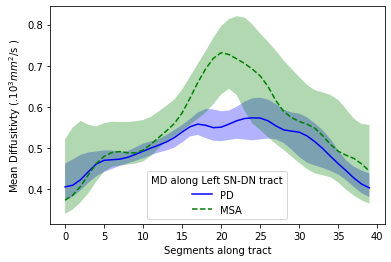

68.0 0.015037328763019926


In [29]:
from scipy import stats

for LAT in ["R","L"]:
    PARA="ADC"
    ALGORITHM="distance_map"
    NR_POINTS=40
    Profiles_file=os.path.join(STUDY_PATH,"tractometry","PARKS_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
    PARKS=np.load(Profiles_file)
    Profiles_file=os.path.join(STUDY_PATH,"tractometry","AMS_P_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
    AMS_P=np.load(Profiles_file)
    Profiles_file=os.path.join(STUDY_PATH,"tractometry","AMS_C_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
    AMS_C=np.load(Profiles_file)
    MSA=np.concatenate((AMS_C,AMS_P),axis=0)

    sigma=1

    plt.plot(skimage.filters.gaussian(np.median(PARKS*1000,axis=0),sigma=sigma),'blue',label="PD")
    per_min=skimage.filters.gaussian(np.percentile(PARKS*1000,25,axis=0),sigma=sigma)
    per_max=skimage.filters.gaussian(np.percentile(PARKS*1000,75,axis=0),sigma=sigma)
    plt.fill_between(np.linspace(0,39,40),per_min,per_max,facecolor='blue', alpha=0.3)

    plt.plot(skimage.filters.gaussian(np.median(AMS*1000,axis=0),sigma=sigma),'g--',label="MSA")
    per_min=skimage.filters.gaussian(np.percentile(AMS*1000,25,axis=0),sigma=sigma)
    per_max=skimage.filters.gaussian(np.percentile(AMS*1000,75,axis=0),sigma=sigma)
    plt.fill_between(np.linspace(0,39,40),per_min,per_max,facecolor='green', alpha=0.3)
    
    if LAT=="L":
        plt.legend(title='MD along Left SN-DN tract',loc='lower center') 
    else:
        plt.legend(title='MD along Right SN-DN tract',loc='lower center') 
    
    plt.xlabel('Segments along tract')
    plt.ylabel('Mean Diffusitivty ($.10^3 mm^2$/s )')
    plt.savefig(os.path.join(STUDY_PATH,'SN_DN_PARKS_VS_AMS'+LAT+'.png'), bbox_inches='tight', dpi=300)
    plt.show()
    t2, p2 = stats.mannwhitneyu(np.median(PARKS[:,19:22],axis=1),np.median(AMS[:,19:22],axis=1),) 
    print(t2,p2)

In [30]:
os.path.join(STUDY_PATH,'SN_DN_PARKS_VS_AMS'+LAT+'.png')

'/NAS/dumbo/protocoles/GAITnPARK/SN_DN_PARKS_VS_AMSL.png'

In [31]:
os.path.join(STUDY_PATH,"tractometry","PARKS_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")

'/NAS/dumbo/protocoles/GAITnPARK/tractometry/PARKS_ADC_L_SN_DN_distance_map_40.npy'

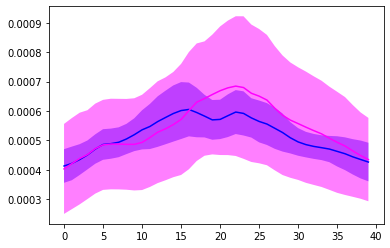

In [9]:
%matplotlib inline

plt.plot(np.mean(PARKS,axis=0),'blue')
plt.fill_between(np.linspace(0,39,40),np.mean(PARKS,axis=0)-np.std(PARKS,axis=0),np.mean(PARKS,axis=0)+np.std(PARKS,axis=0),facecolor='blue', alpha=0.5)

plt.plot(np.mean(AMS,axis=0),'magenta')
plt.fill_between(np.linspace(0,39,40),np.mean(AMS,axis=0)-np.std(AMS,axis=0),np.mean(AMS,axis=0)+np.std(AMS,axis=0),facecolor='magenta', alpha=0.5)
plt.show()

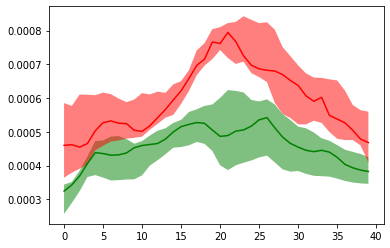

In [36]:
%matplotlib inline

plt.plot(np.median(AMS_P,axis=0),'green')
plt.fill_between(np.linspace(0,39,40),np.percentile(AMS_P,25,axis=0),np.percentile(AMS_P,75,axis=0),facecolor='green', alpha=0.5)

plt.plot(np.median(AMS_C,axis=0),'red')
plt.fill_between(np.linspace(0,39,40),np.percentile(AMS_C,25,axis=0),np.percentile(AMS_C,75,axis=0),facecolor='red', alpha=0.5)

plt.show()

(1, 40)


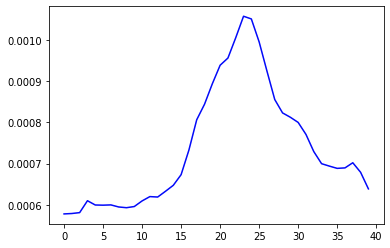

In [83]:
df = pd.read_csv(os.path.join(STUDY_PATH,'AMS_C.txt'), sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

for LAT in ["R","L"]:
    for idx, jdx in df.iterrows():
        npvalues = np.zeros([1,NR_POINTS])
        SUBJ=df.iloc[idx]['subject_id']
        TRACTO_TCK=os.path.join(STUDY_PATH,"DTI",SUBJ,"Tract_SN_DN_"+LAT+"_better_"+SUBJ+"_resampled.tck")
        SCALAR_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"adc.nii.gz")
        START_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"SN_"+LAT+"_"+SUBJ+"_binary_onB0.nii.gz") 
        scalar_image = nib.load(SCALAR_IMG)
        beginnings = nib.load(START_IMG)
        sl_file = nib.streamlines.load(TRACTO_TCK)
        streamlines = sl_file.streamlines
        val=list(length(streamlines))
        if len(streamlines) > 5 :
            mean, std = tractometry.evaluate_along_streamlines_withAlgo(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine,algorithm="distance_map")
            npvalues[0, :] = mean[1:-1]
        Profiles_file=os.path.join(STUDY_PATH,"DTI",SUBJ,PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
        np.savetxt(Profiles_file+".csv",np.transpose(npvalues),delimiter=',')
#    Profiles_file=os.path.join(STUDY_PATH,"AMS_C_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
#    np.save(Profiles_file,npvalues)
#    np.savetxt(Profiles_file+".csv",npvalues,delimiter=',')

print(npvalues.shape)
%matplotlib inline
plt.plot(np.median(npvalues,axis=0),'b')
plt.fill_between(np.linspace(0,39,40),np.percentile(npvalues,25,axis=0),np.percentile(npvalues,75,axis=0))
plt.plot(np.transpose(npvalues),linewidth=0.1)

#plt.plot(numpy.percentile(data,75,axis=0))
#plt.plot(numpy.flipud(numpy.mean(CST_right_nd[numpy.mean(CST_right_nd,axis=1)>0.3],axis=0)))
plt.show()

(1, 40)


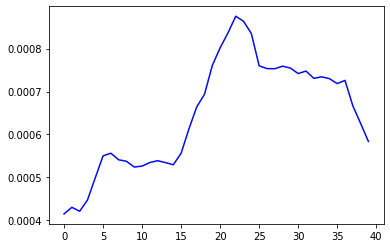

In [82]:
df = pd.read_csv(os.path.join(STUDY_PATH,'AMS_P.txt'), sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

for LAT in ["R","L"]:
    for idx, jdx in df.iterrows():
        npvalues = np.zeros([1,NR_POINTS])
        SUBJ=df.iloc[idx]['subject_id']        
        TRACTO_TCK=os.path.join(STUDY_PATH,"DTI",SUBJ,"Tract_SN_DN_"+LAT+"_better_"+SUBJ+"_resampled.tck")
        SCALAR_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"adc.nii.gz")
        START_IMG=os.path.join(STUDY_PATH,"DTI",SUBJ,"SN_"+LAT+"_"+SUBJ+"_binary_onB0.nii.gz") 
        if os.path.exists(TRACTO_TCK) and os.path.exists(SCALAR_IMG) and os.path.exists(START_IMG) :
            scalar_image = nib.load(SCALAR_IMG)
            beginnings = nib.load(START_IMG)
            sl_file = nib.streamlines.load(TRACTO_TCK)
            streamlines = sl_file.streamlines
            val=list(length(streamlines))
            if len(streamlines) > 5 :
                mean, std = tractometry.evaluate_along_streamlines_withAlgo(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine,algorithm="distance_map")
                npvalues[0, :] = mean[1:-1]
            Profiles_file=os.path.join(STUDY_PATH,"DTI",SUBJ,PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
            np.savetxt(Profiles_file+".csv",np.transpose(npvalues),delimiter=',')
#    Profiles_file=os.path.join(STUDY_PATH,"AMS_P_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS))
#    np.save(Profiles_file,npvalues)
#    np.savetxt(Profiles_file+".csv",npvalues,delimiter=',')

print(npvalues.shape)
%matplotlib inline
plt.plot(np.median(npvalues,axis=0),'b')
plt.fill_between(np.linspace(0,39,40),np.percentile(npvalues,25,axis=0),np.percentile(npvalues,75,axis=0))
plt.plot(np.transpose(npvalues),linewidth=0.1)

#plt.plot(numpy.percentile(data,75,axis=0))
#plt.plot(numpy.flipud(numpy.mean(CST_right_nd[numpy.mean(CST_right_nd,axis=1)>0.3],axis=0)))
plt.show()

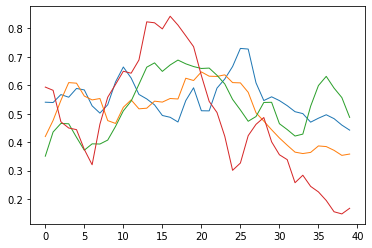

In [40]:
plt.plot(np.transpose(npvalues[1:5,:]),linewidth=1)

In [232]:
from dipy.io.streamline import load_tck
from dipy.io.streamline import save_tck
import os
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,is_header_compatible)
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.tracking.utils import density_map
from dipy.data.fetcher import (fetch_file_formats,get_file_formats)

files=glob.glob(os.path.join(STUDY_PATH,"DTI","*","Tract_SN_DN_*_resampled.tck"))
for file in files :   
    ADCfile=os.path.join(STUDY_PATH,"DTI",file.split("/")[6],"adc.nii.gz")
    img = nib.load(ADCfile)
    dataQuant= img.get_fdata()

    bundle=load_tck(file,ADCfile)
    tmp = select_random_set_of_streamlines(bundle.streamlines,0)
    for cpt,fiber in enumerate(bundle.streamlines):
        tmp.append(fiber[20:25]) 
    #print(bundle.affine, bundle.dimensions)
    dataDensity = density_map(tmp,bundle.affine, bundle.dimensions)
    if file.find("Tract_SN_DN_L_") > 0 :
        #print(file,os.path.join(STUDY_PATH,"DTI",file.split("/")[6],"SN_DN_L_density.nii.gz"))
        nib.save(nib.Nifti1Image(dataDensity, img.affine, img.header ),os.path.join(STUDY_PATH,"DTI",file.split("/")[6],"SN_DN_L_density.nii.gz"))
    else :
        #print(file,os.path.join(STUDY_PATH,"DTI",file.split("/")[6],"SN_DN_R_density.nii.gz"))
        nib.save(nib.Nifti1Image(dataDensity, img.affine, img.header ),os.path.join(STUDY_PATH,"DTI",file.split("/")[6],"SN_DN_R_density.nii.gz"))    
    print(file.split("/")[6],np.sum(np.multiply(dataDensity,dataQuant))/np.sum(dataDensity))

BEDEZ_DIDIER_SES1 0.0004731788615265084
BEDEZ_DIDIER_SES1 0.00045382697211557966
BUNIET_PASCAL_SES1 0.00042321404571422813
BUNIET_PASCAL_SES1 0.00043028103219752044
COUDRON_PAULE_SES1 0.0006316650658845901
CARCAN_JACQUES_SES1 0.00047036354440812157
CARCAN_JACQUES_SES1 0.00047220590732760455
DIETZINGER_GUY_SES1 0.00043170162046445406
DIETZINGER_GUY_SES1 0.0004514170194255379
COUDRON_PAULE_SES2 0.0006507230509206716
DIETZINGER_GUY_SES2 0.0004898416497563455
DIETZINGER_GUY_SES2 0.00047796778080776413
BUNIET_PASCAL_SES2 0.0004892334811774867
BUNIET_PASCAL_SES2 0.0004606568117749148
COUPEZ_PHILIPPE_SES1 0.0004963685845305358
COUPEZ_PHILIPPE_SES1 0.0005076028007667121
BRISFER_JOEL_SES1 0.0004806263633371157
BRISFER_JOEL_SES1 0.0005115381720770529
HUREZ_REGINE_SES2 0.0004985401382095303
HUREZ_REGINE_SES2 0.0005483118311926315
DALLOY_FREDERIQUE_SES1 0.00046994325971630923
DALLOY_FREDERIQUE_SES1 0.0005110937407647227
DALLOY_FREDERIQUE_SES2 0.0005167080905131516
DALLOY_FREDERIQUE_SES2 0.00049270

# Travail résumé IABM & RITS (SFRBM)

In [20]:
PARA="ADC"
ALGORITHM="distance_map"
NR_POINTS=40
Profiles_file=os.path.join(STUDY_PATH,"PARKS_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
PARKS_ADC=np.load(Profiles_file)
Profiles_file=os.path.join(STUDY_PATH,"AMS_P_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
AMS_P_ADC=np.load(Profiles_file)
Profiles_file=os.path.join(STUDY_PATH,"AMS_C_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
AMS_C_ADC=np.load(Profiles_file)

PARA="FA"
Profiles_file=os.path.join(STUDY_PATH,"PARKS_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
PARKS_FA=np.load(Profiles_file)
Profiles_file=os.path.join(STUDY_PATH,"AMS_P_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
AMS_P_FA=np.load(Profiles_file)
Profiles_file=os.path.join(STUDY_PATH,"AMS_C_"+PARA+"_"+LAT+"_SN_DN_"+ALGORITHM+"_"+str(NR_POINTS)+".npy")
AMS_C_FA=np.load(Profiles_file)

In [21]:
AMS_P_ADC_c=np.delete(AMS_P_ADC, (2), axis=0)
AMS_P_FA_c=np.delete(AMS_P_FA, (2), axis=0)

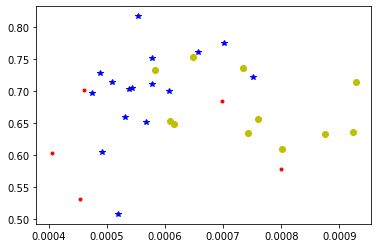

In [32]:
plt.plot(np.mean(PARKS_ADC[:,19:22],axis=1),np.mean(PARKS_FA[:,19:22],axis=1),"*b")
plt.plot(np.mean(AMS_P_ADC_c[:,19:22],axis=1),np.mean(AMS_P_FA[:,19:22],axis=1),".r")
plt.plot(np.mean(AMS_C_ADC[:,19:22],axis=1),np.mean(AMS_C_FA[:,19:22],axis=1),"oy")

# DKI Imaging

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from scipy.ndimage.filters import gaussian_filter

import dipy.reconst.dki_micro as dki_micro
import dipy.reconst.msdki as msdki
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti

In [15]:
data, affine = load_nifti('/NAS/dumbo/protocoles/GAITnPARK/DTI/ANDRIES_JEAN_PIERRE_SES1/data/data.nii.gz')
bvals, bvecs = read_bvals_bvecs('/NAS/dumbo/protocoles/GAITnPARK/DTI/ANDRIES_JEAN_PIERRE_SES1/data/bvals','/NAS/dumbo/protocoles/GAITnPARK/DTI/ANDRIES_JEAN_PIERRE_SES1/data/bvecs')
gtab = gradient_table(bvals, bvecs)
mask,affine_mask = load_nifti('/NAS/dumbo/protocoles/GAITnPARK/DTI/ANDRIES_JEAN_PIERRE_SES1/data/data_mask.nii.gz')

In [16]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

In [18]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth, mask=mask)

dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(data_smooth,mask=mask)

msdki_model = msdki.MeanDiffusionKurtosisModel(gtab)
msdki_fit = msdki_model.fit(data, mask=mask)

DiffusionKurtosisModel(gtab)
dki_microfit = dki_micro_model.fit(data_smooth,mask=mask)
dki_micro_model=dki_micro.dkimicro_prediction(data_smooth,gtab)

In [43]:
dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd
FA = dkifit.fa
MD = dkifit.md
AD = dkifit.ad
RD = dkifit.rd
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3) 
MSD = msdki_fit.msd #mean signal diffusion
MSK = msdki_fit.msk #mean signal kurtosis

In [39]:
# Initialize well aligned mask with ones
well_aligned_mask = np.ones(data.shape[:-1], dtype='bool')

# Diffusion coefficient of linearity (cl) has to be larger than 0.4, thus
# we exclude voxels with cl < 0.4.
cl = dkifit.linearity.copy()
well_aligned_mask[cl < 0.4] = False

# Diffusion coefficient of planarity (cp) has to be lower than 0.2, thus
# we exclude voxels with cp > 0.2.
cp = dkifit.planarity.copy()
well_aligned_mask[cp > 0.2] = False

# Diffusion coefficient of sphericity (cs) has to be lower than 0.35, thus
# we exclude voxels with cs > 0.35.
cs = dkifit.sphericity.copy()
well_aligned_mask[cs > 0.35] = False

# Removing nan associated with background voxels
well_aligned_mask[np.isnan(cl)] = False
well_aligned_mask[np.isnan(cp)] = False
well_aligned_mask[np.isnan(cs)] = False

AWF = dki_micro.axonal_water_fraction

#dki_micro_model.fit(data_smooth, mask=well_aligned_mask)
# = dki_micro_fit.awf
#TORT = dki_micro_fit.tortuosity

AttributeError: 'DiffusionKurtosisFit' object has no attribute 'axonal_water_fraction'